<a href="https://colab.research.google.com/github/Holzlsauer/data-science-bootcamp/blob/main/S%C3%ADrioLiban%C3%AAs_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootcamp Data Science Aplicada - Projeto Final

Autor: **Renato Holzlsauer Mattos Macedo**

Contato: **renato.holzlsauer@gmail.com** - [**Linkedin**](https://www.linkedin.com/in/holzlsauer/) - [**GitHub**](https://github.com/Holzlsauer)

**Contexto**

A pandemia de COVID-19 impactou todo o mundo, e sobrecarregou os sistemas de saúde; que estavam despreparados para tamanha e longa demanda por leitos de UTIs, profissionais especializados, equipamentos de proteção pessoais e recursos hospitalares. O Brasil registrou seu primeiro caso de COVID-19 em 26 de fevereiro de 2020, alcançando a transmissão coletiva em 20 de março do mesmo ano.

Este trabalho objetiva desenvolver um modelo de machine learning capaz de auxiliar profissionais da saúde em suas decisões. O modelo propõe predizer quais pacientes necessitarão de leitos nas UTIs com base em seus dados clínicos.

**Base de dados**

A base de dados que será utilizada no desenvolvimento do modelo foi disponibilizada pelo hospital Sírio-Libanês na plataforma [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), onde algumas instruções são fornecidas para o uso dos dados.


- **Pacientes na UTI**

Aqueles registros na base de dados que constam a internação do paciente devem ser desconsiderados no desenvolvimento do modelo. Os dados nesses casos possuem pouca confiança, uma vez que a internação pode ter ocorrido antes da obtenção dos exames.
![a](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2F77ca2b4635bc4dd7800e1c777fed9de1%2FTimeline%20Example%20No.png?generation=1594740873237462&alt=media)

- **Dados faltantes**

Um dos maiores desafios ao trabalhar com dados de saúde é variação na frequência em que os dados são obtidos. Alguns dados como sinais vitais são muitos mais rápidos de serem obtidos do que aqueles dados que dependem de exames laboratoriais. 

Nesses casos é razoável considerar que o paciente se encontra estável, podendo ser completados esses dados com aqueles presentes nas janelas vizinhas. 


- **Quanto antes, melhor!**

A rápida identificação de que determinado paciente precisará de um leito e cuidados intensos é a chave para o gerenciamento de recursos do hospital e do tratamento adequado, potencialmente salvando vidas.

O desenvolvimento de um modelo utilizando apenas a primeira janela horária (0-2) desde a entrada no hospital dos pacientes é possivelmente a mais relevante, embora modelos que utilizam todos os dados disponíveis possam apresentar uma maior acurácia.


*texto origrinal da [kaggle](https://www.kaggle.com/felipeveiga/starter-covid-19-sirio-libanes-icu-admission)*

# Resumo

O trabalho se divide em algumas seções bem definidas.

**Primeira seção** - Importação das bibliotecas utilizadas na análise dos dados e desenvolvimento do modelo; e criação das funções utilizadas ao longo do notebook.

**Segunda seção** - Realizada do tratamento da base de dados e uma breve exploração da mesma. 

**Terceira seção** - Seleção da janela dos dados e separação dos modelos.

**Quarta seção** - Realizadas a redução e seleção de variáveis. 

**Quinta seção** - Os ajuste dos hiper parâmetros dos modelos.

**Sexta seção** - Comparação dos modelos e apresentação do modelo final.

# Primeira seção - Importações e funções

## Importações

In [320]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Javascript

In [321]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [322]:
!pip install shap;

In [323]:
import shap
shap.initjs()

In [324]:
np.random.seed(15849)

In [325]:
path = 'https://github.com/Holzlsauer/data-science-bootcamp/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'
dados_raw = pd.read_excel(path)

## Funções

In [326]:
def colunas_por_tipo(df):
    """ Exibe as colunas da base de dados agrupadas por tipo de dados """
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    tipos = {
        'demograficos': df.columns[1:4],
        'comorbidades': df.columns[4:13],
        'vitais': df.columns[13:49],
        'laboratoriais': df.columns[49:-2],
        'hospital': list(df.columns[-2:]) + [df.columns[0]]
    }

    for k, v in tipos.items():
        i = 0
        print(f'Colunas com dados do tipo: {k.upper()}\n{"":-<118}')
        for col in v:
            print(f'{col[:22]:<23}\t', end='')
            i+=1
            if not i%5:
                print('')
        print('\n\n')

In [327]:
def relacao_paciente_janela(dataframe:pd.DataFrame):
    """ Retorna o número de pacientes que foram para UTI por janela """
    dataframe.sort_index(inplace=True)
    sum = 0
    internacoes = {'janela': list(dataframe['WINDOW'].unique()), 'internacoes': []}

    for window in dataframe['WINDOW'].unique():
        internacoes['internacoes'].append(dataframe.query('ICU == 1 and WINDOW == @window')['ICU'].sum() - sum)
        sum = sum + internacoes["internacoes"][-1]
        print(f'{internacoes["internacoes"][-1]:>3}: Pacientes que foram para UTI na janela de {window} horas')
            
    print(f'{len(dataframe["PATIENT_VISIT_IDENTIFIER"].unique()) - sum:>3}: Pacientes que não foram para UTI')
    print(f'-------------------------------------------------------------')
    print(f'{len(dataframe["PATIENT_VISIT_IDENTIFIER"].unique()):>3}: Total de pacientes')

    return internacoes

In [328]:
def makebio_df(df:pd.DataFrame):
    """ Função utilizada pelo Sírio-Libanês para a criação de novas 3 variáveis de interesse """

    # Separa as janelas, ICU, dados demograficos e comorbidades
    colunas = df.columns
    df_novosdados = df[colunas[:-2]]

    df_novosdados["BLOODPRESSURE_ARTERIAL_MEAN"] = (df_novosdados['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df_novosdados['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
    df_novosdados["NEUTROPHILES/LINFOCITOS"] = df_novosdados['NEUTROPHILES_MEAN']/df_novosdados['LINFOCITOS_MEAN']
    df_novosdados["GASO"] = df_novosdados.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
    df_novosdados["GASO"] = (~df_novosdados["GASO"].isna()).astype(int)
  
    out = pd.concat([df_novosdados, df[colunas[-2:]]], ignore_index=True, axis=1)
    out.columns = list(df_novosdados.columns) + list(colunas[-2:])

    return out

In [329]:
def preenche_dados(dataframe:pd.DataFrame):
    """
    Retorna o dataframe após o preenchimento dos dados vitais e laboratoriais
    faltantes com ffill e bfill 
    Número de colunas por tipo de dados:
        demographics = 3
        comorbities = 9
        vital_signs = 36
        laboratory = 180
    """

    # Separa as janelas, ICU, dados demograficos e comorbidades
    colunas = dataframe.columns 

    df_preenchido = dataframe.groupby(by=['PATIENT_VISIT_IDENTIFIER'], as_index=False)[colunas[13:-2]]
    df_preenchido = df_preenchido.fillna(method='ffill').fillna(method='bfill')
    
    out = pd.concat([dataframe[colunas[:13]], df_preenchido, dataframe[colunas[-2:]]], ignore_index=True, axis=1)
    out.columns = colunas

    return out

In [330]:
def limpar_janela(dataframe:pd.DataFrame, janela:str):
    """ 
    Retorna um dataframe sem os pacientes que se encontram na UTI na primeira 
    janela, de acordo com o instruido pelo hospital Sírio-Libanês
    """

    df = dataframe.query('ICU == 0 and WINDOW == @janela')
    
    # Informação da parcela de internados na primeira janela
    aux = dataframe.query('WINDOW == @janela')
    print(f'Número de pacientes que foram para UTI na janela {janela}: ', end='')
    print(f'{aux.shape[0] - df.shape[0]} (', end='')
    print(f'{round((1 - df.shape[0]/aux.shape[0])*100, 2)}%)')
    print(f'Total de pacientes na base de dados: {df.shape[0]}')

    pacientes = df['PATIENT_VISIT_IDENTIFIER'].values
    df = dataframe.query('PATIENT_VISIT_IDENTIFIER in @pacientes')

    return df

In [331]:
def plot_pacientes_por_janela(dataframe:pd.DataFrame):
    """ Retorna gráfico de pacientes por janela de internação """
    janelas = list(dataframe['WINDOW'].unique())
    pacientes = []

    s = 0
    for janela in janelas:
        y = dataframe.query('WINDOW == @janela')['ICU'].sum()
        pacientes.append(y - s)
        s = y

    plt.figure(figsize=(10,6))
    plt.title('Admissões em UTI por janela', fontsize=16)
    plot = sns.barplot(x=janelas, y=pacientes, palette='Blues_d')
    for p in plot.patches:
        plot.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
    plt.xlabel('Janela horária', fontsize=14)
    plt.xticks(fontsize=12)
    plt.ylabel('Pacientes', fontsize=14)
    plt.yticks(fontsize=12)

    plt.grid(True, axis='y', linestyle='--')

    plt.show()

In [332]:
def prepara_janela(rows):
    """ 
    Recebe as linhas de um groupby e retorna apenas a da janela 0-2, após popular 
    a coluna 'ICU' caso o paciente tenha sido internado em algum momento 
    """
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=='0-2', "ICU"] = 1
    return rows.loc[rows["WINDOW"] == '0-2']

In [333]:
def substitui_percentil(dados:pd.DataFrame):
    """ Mapeia a coluna AGE_PERCENTIL substituindo por valores inteiros """
    df = dados
    percentil_map = {'10th': 1, '20th': 2, '30th': 3, '40th': 4, '50th': 5, 
                     '60th': 6, '70th': 7, '80th': 8, '90th': 9, 'Above 90th': 10}
    print(percentil_map)
    df['AGE_PERCENTIL'] = df['AGE_PERCENTIL'].map(percentil_map)
    return df

In [334]:
def prepara_dados(dataframe:pd.DataFrame):
    """ Retorna o dataframe com após a aplição da função prepara_janela """
    aux = dataframe.groupby(by=['PATIENT_VISIT_IDENTIFIER']).apply(prepara_janela)
    return aux.reset_index(drop=True)

In [335]:
def treina_modelos(df, modelos, max_depth=3):
    """
    Treina os modelos utilizando validação cruzada e retorna um dataframe 
    com os resultados dos treinos 
    """
    # np.random.seed(84535458)
    np.random.seed(123456)
    df = df.sample(frac=1).reset_index(drop=True)
    x, y = df.drop(['WINDOW', 'ICU'], axis=1), df['ICU']
    r = {} 

    # Separação dos dados
    RKFSplit = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
    
    for modelo in modelos:
        r[modelo.__name__] = []

        for train_index, test_index in RKFSplit.split(x, y):
            x_train, y_train = x.iloc[train_index], y.iloc[train_index]
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            resultados = modelo(n_estimators=1000, max_depth=max_depth, random_state=0)
            resultados.fit(x_train, y_train)

            p = resultados.predict_proba(x_test)[:,1]
            r[modelo.__name__].append(roc_auc_score(y_test, p))
        
    return pd.DataFrame(r)

In [336]:
def plot_comparativo_auc(resultados):
    """ Plota o gráfico comparativo das performances dos modelos """
    plt.figure(figsize=(16,8))
    sns.barplot(data=resultados, palette="Blues_d")

    plt.title('Comparação de AUC médio entre modelos', fontsize=18)
    plt.ylim((0.6,0.85))
    plt.ylabel('AUC', fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Modelo', fontsize=14)
    plt.xticks(fontsize=14)
    plt.grid(True, axis='y')

    plt.show()

In [337]:
def plot_correlacao_tril(df):
    """ Plota heatmap das autocorrelações no dataframe """
    df_corr = abs(df.corr(method='spearman'))
    tril = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)
    df_corr = df_corr.where(tril)

    plt.figure(figsize=(16,12))
    sns.heatmap(data=df_corr, cmap='Blues')
    plt.show()

In [338]:
def cols_alta_correlacao(df, corte):
    """ Retorna as colunas com maior auto correlação entre as do dataframe """
    df_corr = abs(df[df.columns[4:]].corr(method='spearman'))
    df_corr = df_corr - np.eye(N=df_corr.shape[0])

    return [c for c in df_corr.columns if any(df_corr[c] > corte)]

In [339]:
def correlacao(df, corr_corte):
    """
    Testa a correlação entre as colunas, utilizando o método recebido, e exclui
    do df aquelas com correlação acima do valor de corte
    """
    colunas = df.columns[4:-2] # Colunas dos dados vitais e laboratoriais
    dados_corr = df[colunas].corr(method='spearman').abs()
    triu = np.triu(np.ones(dados_corr.shape), k=1).astype(bool) # Triangulo superior para eliminar duplicidade das corr
    dados_corr = dados_corr.where(triu)
    
    features_excluir = [coluna for coluna in dados_corr.columns if any(dados_corr[coluna] > corr_corte)]
    print(f'Variáveis excluidas:\n{features_excluir}')

    df_corr = df.copy()
    df_corr.drop(features_excluir, axis=1, inplace=True)

    return df_corr

In [340]:
def variantes_mais_correlacionadas(df):
    """ 
    Retorna as colunas do dataframe com as derivações dos dados que possui 
    maior correlação com a coluna alvo ICU 
    """

    alvo = df['ICU']
    colunas = [col for col in df.columns[13:-5] if col[-5:] == '_DIFF']
    colunas = [c.split('_DIFF')[0] for c in colunas]

    features = []
    for coluna in colunas:
        cols = [col for col in df.columns[13:-5] if coluna in col]
        features.append(abs(df[cols].corrwith(alvo, method='spearman')).idxmax(axis=0))

    return df[list(df.columns[:13]) + features + list(df.columns[-5:])].copy()

In [341]:
def find_kbest_range(df, modelos):
    """ Encontra o melhor número de features """
    x = df.drop(['WINDOW', 'ICU'], axis=1)
    y = df['ICU']
    k_auc = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, shuffle=True,
                                                        random_state=0, stratify=y)
    for modelo in modelos:
        k_auc[modelo.__name__] = []
        for k in range(1, len(x.columns) + 1):
            seletor = SelectKBest(score_func=f_classif, k=k)
            x_train_kbest = seletor.fit_transform(x_train, y_train)
            x_test_kbest = seletor.transform(x_test)

            m = modelo(random_state=0)
            m.fit(x_train_kbest, y_train)
            p = m.predict(x_test_kbest)
            
            auc = roc_auc_score(y_test, p)
            k_auc[modelo.__name__].append(auc)
    
    resultados = pd.DataFrame(k_auc)
    resultados.index = (range(1, len(x.columns) + 1))
    resultados.reset_index(inplace=True)
    resultados.columns = ['k'] + list(resultados.columns[1:])

    return resultados

In [342]:
def plot_kbest_auc(resultados):
    """ Plot os gráficos comparativos das AUCs obtidas pelo SelectKBest """
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle('Desempenho do modelo por número de features', fontsize=14)

    i, j = 0, 0
    for modelo in modelos:
        ax[i][j].set_title(modelo.__name__)
        ax[i][j].set_ylabel('AUC')
        ax[i][j].set_ylim(0.50, 0.86)
        ax[i][j].set_xlabel('Número de variáveis')
        ax[i][j].grid(True)
        sns.lineplot(ax=ax[i][j], data=resultados, x='k', y=modelo.__name__)
        
        if j == 1: j, i = 0, 1
        else: j = j + 1
    plt.show()

In [343]:
def colunas_kbest(df, modelo, k):
    """ 
    Treina o modelo utilizando k features, retornando as que tiveram 
    melhor resultado e o seu score 
    """
    x = df.drop(['WINDOW', 'ICU'], axis=1)
    y = df['ICU']
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, shuffle=True,
                                                        random_state=0, stratify=y)        

    seletor = SelectKBest(score_func=f_classif, k=k)
    x_train_kbest = seletor.fit_transform(x_train, y_train)
    best_features = x.columns[seletor.get_support()]

    x_test_kbest = seletor.transform(x_test)

    m = modelo(random_state=0)
    m.fit(x_train_kbest, y_train)
    p = m.predict(x_test_kbest)

    auc = roc_auc_score(y_test, p)
    
    return best_features, auc

In [344]:
def params_tunning(df, modelo, params):
    """ Realiza o tunning do parâmetros no modelo """
    np.random.seed(123456)
    dados = df.sample(frac=1)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['WINDOW', 'ICU'], axis=1)

    print(f'---{modelo.__name__:^25}-----------------------------------------------')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

    modelo = modelo(n_estimators = 1000, n_jobs=-1)

    modelo_gridcv = GridSearchCV(estimator=modelo, param_grid=params, n_jobs=-1,
                                scoring='roc_auc', cv=cv, verbose=1, 
                                return_train_score=True)
    modelo_gridcv.fit(x, y)
    print('---------------------------------------------------------------------------')
    print(f'Melhor score: {modelo_gridcv.best_score_}')
    print(f'Melhores parâmetros: {modelo_gridcv.best_params_}')

In [345]:
def limpa_params(params):
    """ Remove os items do dicionário de suas listas """
    for k, v in params.items():
        params[k] = v[0]
    
    return params

In [346]:
def treina_modelo_tunado(df, modelo, params):
    """ Treinamento do modelo utilizando parametros ajustados """
    # np.random.seed(84535458)
    np.random.seed(123456)
    df = df.sample(frac=1).reset_index(drop=True)
    x, y = df.drop(['WINDOW', 'ICU'], axis=1), df['ICU']

    # Separação dos dados
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
    modelo_t = modelo(n_jobs=-1, random_state=0).set_params(**params)
    r = cross_validate(estimator=modelo_t, X=x, y=y, cv=cv, scoring='roc_auc', 
                       n_jobs=-1, return_estimator=True, verbose=1)   

    r = pd.DataFrame(r)    
    melhor_modelo = r[r.test_score == r.test_score.max()]
    melhor_modelo = melhor_modelo['estimator'].values[0]

    return r, melhor_modelo

In [347]:
def compara_desempenho(r_randomforest_t, r_xgboost_t):
    """ Exibe um dataframe com a comparação entre os modelos """
    resultados_ajustes = r_randomforest_t.copy()
    resultados_ajustes['XGBClassifier'] = r_xgboost_t['test_score']
    resultados_ajustes.drop(['fit_time', 'score_time', 'estimator'], axis=1, inplace=True)
    resultados_ajustes.columns = ['RandomForestClassifier', 'XGBClassifier']
    
    return resultados_ajustes.describe().T

In [348]:
def explica_modelo(modelo, df):
    """ Plota o gráfico de contribuição das features no modelo """
    y = df['ICU']
    x = df.drop(['WINDOW', 'ICU'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, shuffle=True,
                                                        random_state=0, stratify=y)

    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(x_train)
    shap.summary_plot(shap_values, x_train)

In [349]:
def plot_variaveis_por_janela(df, variaveis):
    """ Plota gráfico das variáveis ao longo das janelas """
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,3), sharex=True)
    for i in range(len(variaveis)):
        sns.lineplot(data=dados_raw, x='WINDOW', y=variaveis[i], hue='ICU', ax=ax[i])
        ax[i].set_title(f'{variaveis[i]} POR JANELA', fontsize=14)
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles, ['Não', 'Sim'], title='Foi para UTI')
    
    plt.show()

In [350]:
def shap_feature_importance(modelo, df):
    """ Plota o gráfico de contribuição das features no modelo """
    y = df['ICU']
    x = df.drop(['WINDOW', 'ICU'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, shuffle=True,
                                                        random_state=0, stratify=y)

    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(x_train)
    shap_sum = np.abs(shap_values).mean(axis=0)
    r = pd.DataFrame([x_train.columns.tolist(), shap_sum.tolist()]).T
    r.columns = ['column_name', 'shap_importance']
    r = r.sort_values('shap_importance', ascending=False)

    plt.figure(figsize=(14,8))
    sns.barplot(data=r, x='shap_importance', y='column_name', palette='Blues_d')
    plt.title('Feature importance do modelo de maior AUC', fontsize=14)
    plt.xlabel('Feature importance', fontsize=12)
    plt.xticks(np.arange(0, 0.45, step=0.02))
    plt.ylabel('Variável', fontsize=12)
    plt.grid(True, axis='x')

    return r.T

In [351]:
def relatorio_geral(df, modelo):
    """ Plota gráficos de desempenho e retorna o classification_report """
    y, x = df['ICU'], df.drop(['WINDOW', 'ICU'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, shuffle=True,
                                                        random_state=0, stratify=y)
    modelo.fit(x_train, y_train)
    p = modelo.predict(x_test)
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))
    plot_confusion_matrix(modelo, x_test, y_test, ax=ax[0], normalize="true", cmap="Blues")
    plot_roc_curve(modelo, x_test, y_test, ax=ax[1])
    ax[0].set_title('Matriz de confusão', fontsize=14)
    ax[0].set_ylabel('Resultado verdadeiro', fontsize=12)
    ax[0].set_xlabel('Resultado predizido', fontsize=12)
    ax[1].set_title('Curva ROC', fontsize=14)
    ax[1].set_ylabel('Positivo verdadeiro', fontsize=12)
    ax[1].set_xlabel('Falso positivo', fontsize=12)
    plt.show()

    return classification_report(y_test, p, target_names=['UTI - NÃO', 'UTI - SIM'])

---

# Segunda seção - Tratamento e exploração dos dados

Junto à base de dados no kaggle é possível encontrar um [notebook](https://www.kaggle.com/felipeveiga/starter-covid-19-sirio-libanes-icu-admission) inicial desenvolvido pela equipe de ciência de dados do hospital Sírio-Libanês. Neste, é descrito com mais detalhes como estão organizados os tipos de dados da base e como estes dados foram expandidos.

A base de dados é composta por:

**Dados demograficos** (3 colunas, [1-3])

    Percentil Age.
    Above 65 years old.
    Gender.

**Comorbidades** (9 colunas, [4-12]) 


    The features were created based on the historical ICD-10 codes of each patient using the Charlson and Elixhauser 
    range of comorbid conditions (https://pubmed.ncbi.nlm.nih.gov/16224307/ https://pubmed.ncbi.nlm.nih.gov/9431328/). 
    Here, we have chosen the comorbid groups related to serious adverse outcomes in COVID-19.

**Sinais vitais** (36 colunas, [13-48])

    Diastolic blood pressure.
    Systolic blood pressure.
    Heart rate.
    Respiratory rate.
    Temperature.
    Oxygen saturation.

**Dados laboratoriais** (180 colunas, [49-228])

    There are 36 laboratorys types.

**Dados hospitalares** (3 colunas, [0, 229-230])

    Patient visit identifier
    Time window
    ICU admission

Salienta-se também a forma em que os dados de sinais vitais e laboratoriais estão presentes. Foram disponibilizados os dados de média, mediana, valor mínimo e máximo, amplitude e amplitude relativa.


In [352]:
colunas_por_tipo(dados_raw)

<IPython.core.display.Javascript object>

Colunas com dados do tipo: DEMOGRAFICOS
----------------------------------------------------------------------------------------------------------------------
AGE_ABOVE65            	AGE_PERCENTIL          	GENDER                 	


Colunas com dados do tipo: COMORBIDADES
----------------------------------------------------------------------------------------------------------------------
DISEASE GROUPING 1     	DISEASE GROUPING 2     	DISEASE GROUPING 3     	DISEASE GROUPING 4     	DISEASE GROUPING 5     	
DISEASE GROUPING 6     	HTN                    	IMMUNOCOMPROMISED      	OTHER                  	


Colunas com dados do tipo: VITAIS
----------------------------------------------------------------------------------------------------------------------
ALBUMIN_MEDIAN         	ALBUMIN_MEAN           	ALBUMIN_MIN            	ALBUMIN_MAX            	ALBUMIN_DIFF           	
BE_ARTERIAL_MEDIAN     	BE_ARTERIAL_MEAN       	BE_ARTERIAL_MIN        	BE_ARTERIAL_MAX        	BE_ARTERIAL_DIFF 

In [353]:
dados_raw.shape

(1925, 231)

In [354]:
dados_raw.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

Nota-se uma diferença entre a quantidade total de registros na base de dados e o maior valor entre a identificação do paciente. Essa diferença entre quantidade de registros e total de pacientes dá-se por conta de serem registradas 5 entradas na base de dados para cada paciente.

Cada uma dessas entradas na base de dados de cada paciente corresponde a um intervalo de hora desde a chegada do paciente no hospital. Estas informações estão anotadas na coluna **window**. Esses intervalos são:

    0-2, 2-4, 4-6, 6-12, ABOVE_12

E na coluna **icu** está registrado se aquele paciente se encontra na UTI naquele momento ou não

    1 - Está na UTI 
    2 - Não está na UTI

Abaixo segue um exemplo das entradas de um paciente na base de dados.

In [355]:
dados_raw.head() # Exemplo de registros de um paciente

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

O número total de pacientes presentes na base de dados pode ser obtido com auxílio da coluna **patient_visit_identifier**. Também pode ser vista a quantidade de internações por janela.

In [356]:
# Verificando número real de pacientes
print(f"Número real de pacientes: {len(dados_raw['PATIENT_VISIT_IDENTIFIER'].unique())}")

Número real de pacientes: 385


In [357]:
internacoes_por_janela = relacao_paciente_janela(dados_raw)

 32: Pacientes que foram para UTI na janela de 0-2 horas
 27: Pacientes que foram para UTI na janela de 2-4 horas
 40: Pacientes que foram para UTI na janela de 4-6 horas
 31: Pacientes que foram para UTI na janela de 6-12 horas
 65: Pacientes que foram para UTI na janela de ABOVE_12 horas
190: Pacientes que não foram para UTI
-------------------------------------------------------------
385: Total de pacientes


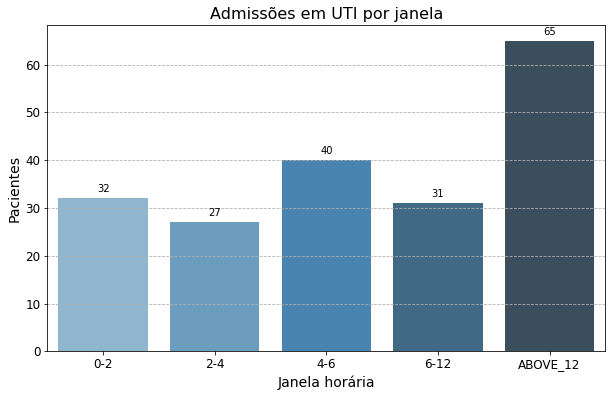

In [358]:
plot_pacientes_por_janela(dados_raw)

## Tratamento dos dados

Antes de prosseguir com a limpeza do dados, a equipe do Sírio-Libanês disponibilizou uma função para a criação de outras features importantes e que possam auxiliar no desenvolvimento do modelo.

    def makebio_df(df:pd.DataFrame):

        df["BLOODPRESSURE_ARTERIAL_MEAN"] = (DataFrame['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
        df["NEUTROPHILES/LINFOCITOS"] = df['NEUTROPHILES_MEAN']/df['LINFOCITOS_MEAN']

        df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
        df["GASO"] = (~df["GASO"].isna()).astype(int)

        return df[["ICU","WINDOW",
                   "PATIENT_VISIT_IDENTIFIER",
                   "AGE_ABOVE65", 
                   "GENDER", 
                   "BLOODPRESSURE_ARTERIAL_MEAN", 
                   "RESPIRATORY_RATE_MAX", 
                   "HTN", 
                   'DISEASE GROUPING 1',
                   'DISEASE GROUPING 2',
                   'DISEASE GROUPING 3',
                   'DISEASE GROUPING 4',
                   'DISEASE GROUPING 5',
                   'DISEASE GROUPING 6',
                   "GASO",
                   "OXYGEN_SATURATION_MIN",
                   "HEART_RATE_MAX",
                   "PCR_MEAN",
                   "CREATININ_MEAN"]]

Essa função será ajustada e aplicada na base de dados.

In [359]:
dados = makebio_df(dados_raw)

A seguir será feito o tratamento dos dados da coluna **age_percentil** de texto para número, para que possam ser trabalhados pelos modelos.

Após isso serão preenchidos os dados dados faltantes. Assim como pode ser verificado no [notebook inicial](https://www.kaggle.com/felipeveiga/starter-covid-19-sirio-libanes-icu-admission), os dados se enquadram em 4 tipos de dados:

    Demographics
    Comorbities 
    Vital Signs 
    Laboratory

Os tipos de dados a serem verificados se apresentam dados faltantes são os vitais e laboratoriais.
Conforme indicado pelo hospital Sírio-Libanês, a estratégia adotada para o tratamento dos dados faltantes será propagar os dados da janela anterior do paciente para a janela com o dado faltante, e então o processo inverso no caso de ainda haver dados não vazios.

    It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable,
    potentially presenting vital signs and blood labs similar to neighboring windows.

In [360]:
dados = substitui_percentil(dados_raw)

{'10th': 1, '20th': 2, '30th': 3, '40th': 4, '50th': 5, '60th': 6, '70th': 7, '80th': 8, '90th': 9, 'Above 90th': 10}


In [361]:
dados = preenche_dados(dados)

In [362]:
# Verifica se há dados vitais e laboratoriais vazios 
print(f'Dados vazios: {dados.iloc[:,13:-2].isna().sum().sum()}') # Soma da soma de dados NaN por coluna

Dados vazios: 0


In [363]:
# Verifica se há dados não informados nas colunas ICU e WINDOW
dados.iloc[:,-2:].isna().sum()

WINDOW    0
ICU       0
dtype: int64

In [364]:
# Verifica se há dados demograficos e de comorbidades vazios
dados.iloc[:,:13].isna().sum()

PATIENT_VISIT_IDENTIFIER    0
AGE_ABOVE65                 0
AGE_PERCENTIL               0
GENDER                      0
DISEASE GROUPING 1          5
DISEASE GROUPING 2          5
DISEASE GROUPING 3          5
DISEASE GROUPING 4          5
DISEASE GROUPING 5          5
DISEASE GROUPING 6          5
HTN                         5
IMMUNOCOMPROMISED           5
OTHER                       5
dtype: int64

Entre os registros encontra-se alguns com dados referentes a comorbidades faltando. Ao inspecionar os dados, verifica-se que se trata de apenas um paciente, o de número **199**. Estes registros serão descartados da amostra.

In [365]:
# Localiza as linhas com dados vazios
dados.loc[dados.isna().any(axis=1)]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
995,199,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978183,-1.0,0.333333,-0.076923,-0.283019,-0.525424,0.035714,0.684211,0.333333,-0.076923,-0.283019,-0.517241,0.035714,0.684211,0.443299,0.125,-0.162393,-0.428571,0.406593,0.878788,-0.076923,-0.351351,-0.432836,-0.575758,-0.15942,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
996,199,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978183,-1.0,0.333333,-0.076923,-0.283019,-0.525424,0.035714,0.684211,0.333333,-0.076923,-0.283019,-0.517241,0.035714,0.684211,0.443299,0.125,-0.162393,-0.428571,0.406593,0.878788,-0.076923,-0.351351,-0.432836,-0.575758,-0.15942,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
997,199,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978183,-1.0,0.333333,-0.076923,-0.283019,-0.525424,0.035714,0.684211,0.333333,-0.076923,-0.283019,-0.517241,0.035714,0.684211,0.443299,0.125,-0.162393,-0.428571,0.406593,0.878788,-0.076923,-0.351351,-0.432836,-0.575758,-0.15942,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4-6,0
998,199,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978183,-1.0,0.333333,-0.076923,-0.283019,-0.525424,0.035714,0.684211,0.333333,-0.076923,-0.283019,-0.517241,0.035714,0.684211,0.443299,0.125,-0.162393,-0.428571,0.406593,0.878788,-0.076923,-0.351351,-0.432836,-0.575758,-0.15942,0.684211,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6-12,0
999,199,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.978183,

In [366]:
dados.dropna(inplace=True)

O próximo passo no tratamento dos dados será a remoção dos dados daqueles que se encontram na UTI na primeira janela, uma vez que assim como mencionado na seção _**Call to Action**_, os dados de pacientes em internação não devem ser utilizados na análise.

In [367]:
dados_selecionados = limpar_janela(dados, '0-2')

Número de pacientes que foram para UTI na janela 0-2: 32 (8.33%)
Total de pacientes na base de dados: 352


# Terceira seção - Escolha dos modelos e separação dos dados

## Modelos
---

Inicialmente serão utilizado alguns modelos nos treinamentos. O intuito é utilizar esses modelos sem nenhuma ajuste, afim de criar uma baseline e então selecionar dela aquele modelo que obteve melhor desempenho em média. 

Por se tratar de um problema de classificação binária (se um paciente precisará ou não de um leito na UTI) os molhores modelos para esse tipo de tarefa são os classificadores. Os modelos escolhidos para o desenvolvimento deste trabalho serão:

    RandomForestClassifier
    ExtraTreesClassifier
    LGBMClassifier
    XGBClassifier


In [368]:
# Modelos para treino
modelos = (
    RandomForestClassifier,
    ExtraTreesClassifier, 
    LGBMClassifier, 
    XGBClassifier,
)

## Primeiras horas
--- 

A estratégia será utilizar os dados da primeira janela de internação para tentar predizer se determinado paciente será internado em algum momento ou não, de acordo com o descrito pelo hospital Sírio-Libanês em ***The earlier, the better!***

Para isso, será registrado na própria coluna **icu** se aquele paciente em algum momento foi para a UTI nas demais janelas ou não.

Aqui será feito o primeiro treinamento dos modelos. Em linhas gerais, estão sendo utilizadas validações cruzadas em cinco divisões, repetidas dez vezes, para a mensuração do desempenho dos modelos. 

Trata-se também de um problema onde é importante garantir todos positivos e negativos verdadeiros e minimizar os falsos; o que seria evitar mandar um paciente para casa e ele precisar de internação, ou alocar um leito para um paciente que não irá necessitar. Por isso a métrica de avaliação que será adotada nos treinamentos será a **auc**.

In [369]:
dados_primeiras_horas = prepara_dados(dados_selecionados)
print(f'DADOS_PRIMEIRAS_HORAS: {dados_primeiras_horas.shape[0]} linhas e {dados_primeiras_horas.shape[1]} colunas')

DADOS_PRIMEIRAS_HORAS: 352 linhas e 231 colunas


Abaixo será aplicada uma função onde os modelos serão treinados utilizando a base de dados fornecida, e utilizando validação cruzada.

In [370]:
# Treino dos modelos
resultados_base = treina_modelos(dados_primeiras_horas, modelos)
resultados_base.describe().T

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,50.0,0.791706,0.039136,0.698191,0.771519,0.793885,0.812600,0.881245
ExtraTreesClassifier,50.0,0.795888,0.042105,0.696546,0.772079,0.791492,0.819059,0.905901
LGBMClassifier,50.0,0.764742,0.046762,0.664274,0.742468,0.764391,0.793387,0.865954
XGBClassifier,50.0,0.783573,0.043830,0.669856,0.762373,0.789100,0.813268,0.869779


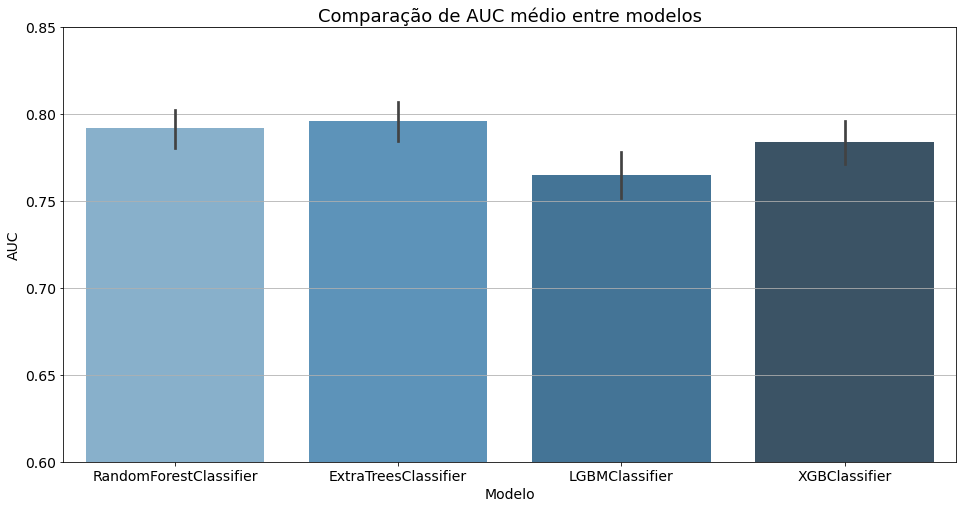

In [371]:
plot_comparativo_auc(resultados_base)

Esses resultados utilizando modelos sem nenhum ajuste de hiper parâmetros ou seleção de features serão a baseline para o desenvolvimento dos modelos.

# Quarta seção - Manipulação de variáveis

Uma etapa importante no desenvolvimento de um modelo de machine learning é a manipulação da base de dados em respeito a suas variáveis. Trata-se de se elencar as variáveis mais relevantes para o modelo e remover aquelas prejudiciais para este.

Algumas das possíveis abordagens consistem na remoção de variáveis altamente correlacionadas entre si e das de baixa correlação com a variável alvo (utilizada para a classificação do problema).

## Redução de features
---

A maioria dos modelos de machine learning prevê que o número de registros dos dados de entrada é muito menor que o número de features **(p << n)**. Nossa base de dados utilizada atualmente consta com 234 colunas para um total de 352 registros, o que pode tornar nosso modelo mais sucetivel a um overfitting.

    A major problem with p >> n problems when using machine learning models is overfitting the training dataset.

    Given the lack of samples, most models are unable to generalize and instead learn the statistical noise in the training data. 
    This makes the model perform well on the training dataset but perform poorly on new examples from the problem domain.
[fonte](https://machinelearningmastery.com/how-to-handle-big-p-little-n-p-n-in-machine-learning/)

<br>Para contornar esse possível problema e tornar nossa base de dados mais apta para ser trabalhada iremos realizar alguns processos sobre ela.

### Variantes de maior correlação
---
O primeiro passo será eliminar a redundância de informações presente na base de dados. As informações de sinais vitais e exames laboratoriais presentes na base de dados foram expandidos em:

média(**mean**), mediana(**median**), valor mínimo(**min**) e máximo(**max**), amplitude(**diff**) e, no caso dos vitais, amplitude relativa(**rel**).


A amplitudes e amplitude relativa foram criadas como se mostra a seguir:

    amplitude (diff): max-min
    relative amplitude (rel): amplitude/median

Obviamente esses dados podem trazer informações válidas sobre a situação atual do paciente, porém elas são medidas de uma mesma característica. Para fazer uma melhor seleção de qual variação dessa medida usar, será analisada a correlação dessas variantes com a variável alvo **icu** e descartada as variantes de menor correlação.

In [372]:
dados_preparados = variantes_mais_correlacionadas(dados_primeiras_horas)
dados_preparados.shape

(352, 60)

In [373]:
dados_preparados.columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'BE_ARTERIAL_MEDIAN',
       'BE_VENOUS_MEDIAN', 'BIC_ARTERIAL_MEDIAN', 'BIC_VENOUS_MEDIAN',
       'BILLIRUBIN_MEDIAN', 'BLAST_MEDIAN', 'CALCIUM_MEDIAN',
       'CREATININ_MEDIAN', 'FFA_MEDIAN', 'GGT_MEDIAN', 'GLUCOSE_MEDIAN',
       'HEMATOCRITE_MEDIAN', 'HEMOGLOBIN_MEDIAN', 'INR_MEDIAN',
       'LACTATE_MEDIAN', 'LEUKOCYTES_MEDIAN', 'LINFOCITOS_MEDIAN',
       'NEUTROPHILES_MEDIAN', 'P02_ARTERIAL_MEDIAN', 'P02_VENOUS_MEDIAN',
       'PC02_ARTERIAL_MEDIAN', 'PC02_VENOUS_MEDIAN', 'PCR_MEDIAN',
       'PH_ARTERIAL_MEDIAN', 'PH_VENOUS_MEDIAN', 'PLATELETS_MEDIAN',
       'POTASSIUM_MEDIAN', 'SAT02_ARTERIAL_MEDIAN', 'SAT02_VENOUS_MEDIAN',
       'SODIUM_MEDIAN', 'TGO_MEDIAN', 'TGP_MEDIAN', 'TTPA_MEDIAN',
    

Esse processo já reduz o número de variáveis para um quarto da quantia original, reduzindo drásticamente a possibilidade de overfitting.

### Variáveis altamente correlacionadas entre si
---

A presença de variáveis com alta correlação entre si pode trazer problemas para o modelo. A alta correlação entre duas variáveis pode estar relacionada a uma redundância de informações entre os dados, por serem medições de características similares. A fim de evitar qualquer possível redundância no modelo, expandindo sua capacidade de generalizar, serão descartadas essas variáveis.

Abaixo podem ser vistas quais variáveis possuem alta correlação entre si. Serão identificadas e descartadas aquelas variáveis de sinais vitais e exames laboratoriais com correlação acima de **0.85**.

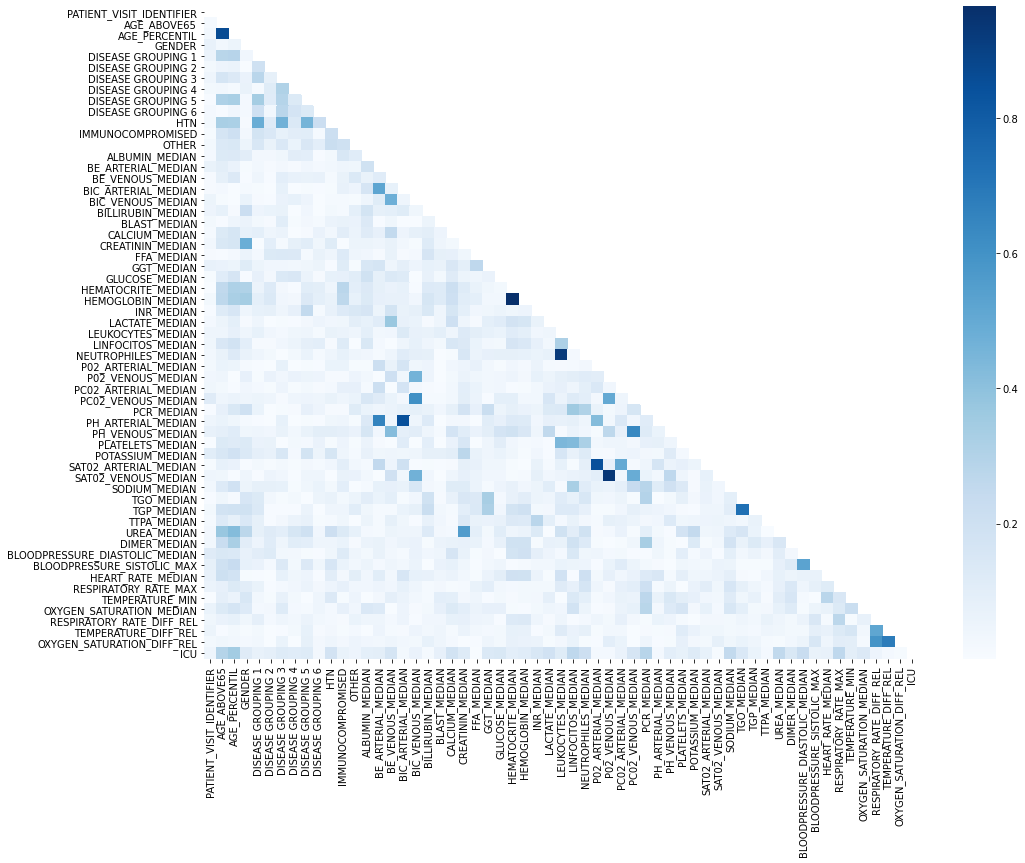

In [374]:
plot_correlacao_tril(dados_preparados)

In [375]:
cols_alta_correlacao(dados_preparados, 0.85)

['HEMATOCRITE_MEDIAN',
 'HEMOGLOBIN_MEDIAN',
 'LEUKOCYTES_MEDIAN',
 'NEUTROPHILES_MEDIAN',
 'P02_VENOUS_MEDIAN',
 'SAT02_VENOUS_MEDIAN']

In [376]:
dados_preparados = correlacao(dados_preparados, 0.85)

Variáveis excluidas:
['HEMOGLOBIN_MEDIAN', 'NEUTROPHILES_MEDIAN', 'SAT02_VENOUS_MEDIAN']


In [377]:
dados_preparados.shape

(352, 57)

### Resultados após redução de features
---

Podemos verificar ainda como ficam os resultados obtidos pelos modelos após a redução de variáveis realizada.

In [378]:
# Treino dos modelos
resultados = treina_modelos(dados_preparados, modelos)
resultados.describe().T

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,50.0,0.801474,0.038362,0.707617,0.774845,0.800576,0.827275,0.874801
ExtraTreesClassifier,50.0,0.775387,0.051226,0.671875,0.740059,0.777187,0.811509,0.894737
LGBMClassifier,50.0,0.761449,0.046261,0.646730,0.729260,0.768572,0.791523,0.858313
XGBClassifier,50.0,0.780720,0.041507,0.657895,0.761431,0.780463,0.804706,0.870066


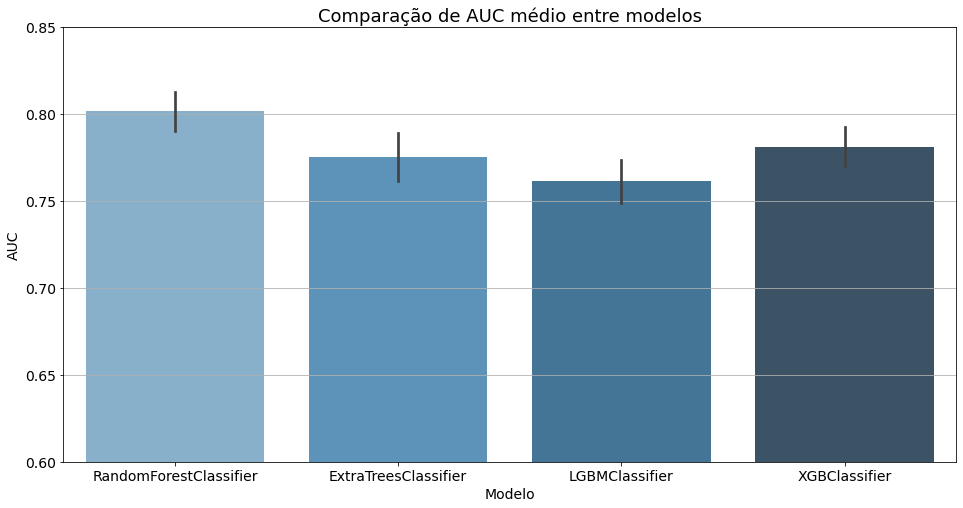

In [379]:
plot_comparativo_auc(resultados)

In [380]:
# Diferença entre modelos atuais e modelo de base
resultados.describe().T - resultados_base.describe().T

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,0.0,0.009768,-0.000774,0.009426,0.003326,0.006691,0.014675,-0.006444
ExtraTreesClassifier,0.0,-0.020501,0.009121,-0.024671,-0.032021,-0.014306,-0.007550,-0.011164
LGBMClassifier,0.0,-0.003293,-0.000501,-0.017544,-0.013208,0.004181,-0.001864,-0.007641
XGBClassifier,0.0,-0.002853,-0.002323,-0.011962,-0.000942,-0.008637,-0.008562,0.000287


Podemos ver que comparado com a nossa base, a redução dos dados já nos ofereceu uma melhoria nos nossos modelos, apesar de pequena.

## Seleção de features
---

Após realizar a redução das variáveis presentes na base de dados, o próximo passo será identificar quantas e quais dessas variáveis nos proporcionará um melhor desempenho dos modelos.

O método que será utilizado para realizar essa identificação é o SelectKBest disponibilizado na Sci-kit Learn. Esse método busca excluir todas, exceto as _k_ melhores features.

Foi identificado um intervarlo de quantidade de variáveis que proporciona um desempenho melhor aos modelos. Os modelos RandomForestClassifier e ExtraTreesClassifier apresentam uma estabilidade entre 75% e 85% de auc, enquanto o LGBMClassifier e XGBClassifier apresentam uma melhora em torno de 30 variáveis.

Todos os treinamentos foram realizados utilizando um split de 80/20 nos dados para treino e teste. 

In [381]:
resultados_kbest = find_kbest_range(dados_preparados, modelos)

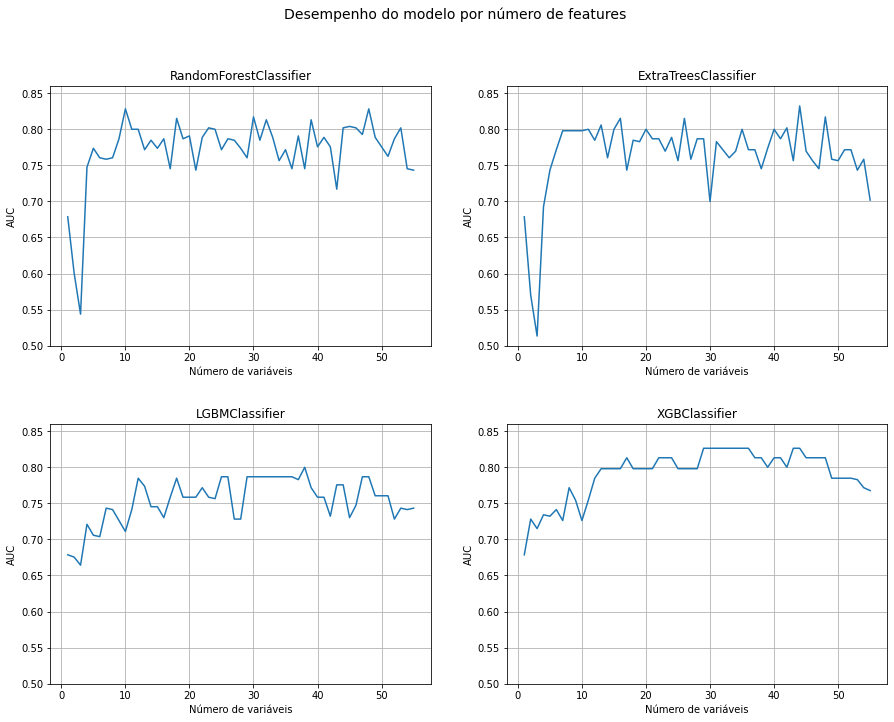

In [382]:
plot_kbest_auc(resultados_kbest)

In [383]:
for modelo in modelos:
    colunas, auc = colunas_kbest(dados_preparados, modelo, 30)
    print(f'MODELO: {modelo.__name__:<23}\nAUC: {auc}\nCOLUNAS: {colunas}')
    print('--------------------------------------------------------------------------------')

MODELO: RandomForestClassifier 
AUC: 0.8169856459330145
COLUNAS: Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'HTN',
       'ALBUMIN_MEDIAN', 'BIC_VENOUS_MEDIAN', 'CALCIUM_MEDIAN',
       'CREATININ_MEDIAN', 'GLUCOSE_MEDIAN', 'HEMATOCRITE_MEDIAN',
       'INR_MEDIAN', 'LACTATE_MEDIAN', 'LEUKOCYTES_MEDIAN',
       'LINFOCITOS_MEDIAN', 'P02_ARTERIAL_MEDIAN', 'PC02_VENOUS_MEDIAN',
       'PCR_MEDIAN', 'PH_VENOUS_MEDIAN', 'POTASSIUM_MEDIAN',
       'SAT02_ARTERIAL_MEDIAN', 'SODIUM_MEDIAN', 'UREA_MEDIAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MAX',
       'RESPIRATORY_RATE_MAX', 'OXYGEN_SATURATION_MEDIAN'],
      dtype='object')
--------------------------------------------------------------------------------
MODELO: ExtraTreesClassifier   
AUC: 0.6997607655502392
COLUNAS: Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1',
       'DISEASE GROUPING 

In [384]:
colunas = list(colunas) + ['WINDOW', 'ICU']

In [385]:
# Treino dos modelos
resultados = treina_modelos(dados_preparados[colunas], modelos)
resultados.describe().T

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,50.0,0.803834,0.039786,0.708931,0.778851,0.801809,0.828382,0.868421
ExtraTreesClassifier,50.0,0.777288,0.048786,0.680590,0.744219,0.777113,0.811565,0.881579
LGBMClassifier,50.0,0.754898,0.055869,0.552826,0.723291,0.760367,0.789323,0.870813
XGBClassifier,50.0,0.780308,0.045210,0.638821,0.756990,0.785800,0.806393,0.877193


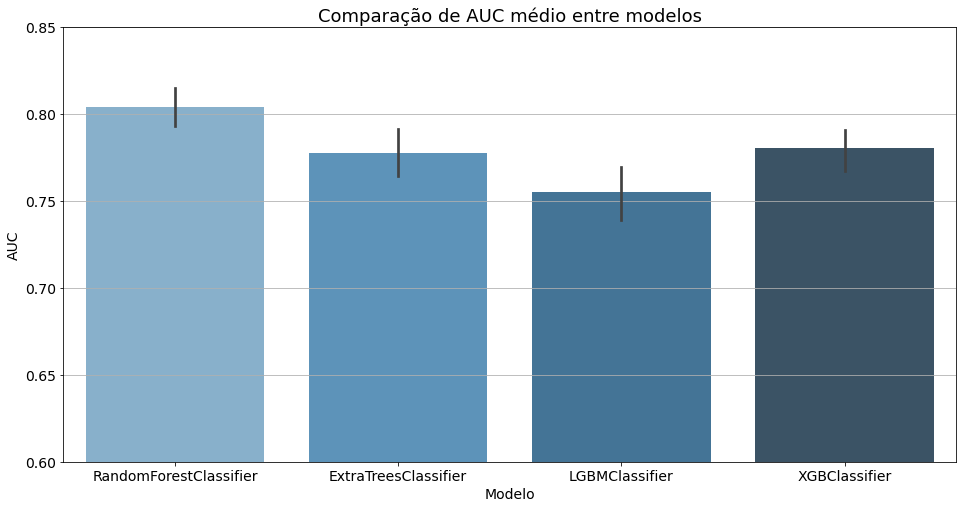

In [386]:
plot_comparativo_auc(resultados)

In [387]:
# Diferença entre modelos atuais e modelo de base
resultados.describe().T - resultados_base.describe().T

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,0.0,0.012128,0.000651,0.010741,0.007332,0.007925,0.015782,-0.012824
ExtraTreesClassifier,0.0,-0.018600,0.006681,-0.015956,-0.027861,-0.014379,-0.007494,-0.024322
LGBMClassifier,0.0,-0.009844,0.009107,-0.111449,-0.019177,-0.004025,-0.004065,0.004859
XGBClassifier,0.0,-0.003265,0.001380,-0.031036,-0.005383,-0.003300,-0.006875,0.007414


Novamente nota-se um aumento na performance do modelo RandomForestClassifier após a aplicação do método de seleção de variáveis, diminuindo ainda mais a quantidade delas para o treinamento do modelo.

# Quinta seção - Ajuste de hiperparâmetros

Como pode ser observado no gráfico e na tabela comparativa anterior, o modelo com base no RandomForestClassifier obteve um desempenho e melhora superiores aos outros modelos comparados.

Outro modelo que apresentou uma performance razoável foi o XGBClassifier, apesar da pequena queda de desempenho. Ambos serão levados adiante para o ajuste de seus hiperparâmetros a fim de melhorar ainda mais sua performance.

Esses hiperparâmetros serão ajustados utilizando o GridSearchCV, onde são gerados espaços a partir dos possíveis valores para os parâmetros, sendo testados um a um e destacadas as melhores combinações.

## XGBClassifier
---

A descrição detalhada dos hiper parâmetros e os seus possíveis valores podem ser consultados na [documentação](https://xgboost.readthedocs.io/en/latest/parameter.html) do modelo. Além disso os parâmetros padrão dos modelos podem ser acessados através do métodos _get_params()_.

In [388]:
XGBClassifier().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

Os parâmetros serão ajustados aos poucos por questões computacionais. Primeiramente serão ajustados o número de camadas de árvores do modelo(_max_depth_), e o valor mínimo para que uma árvore precisa para continuar sendo sub seccionada (_min_child_weight_). Esses ajustes serão realizados mantendo os parâmetros *subsample* (fração para treino das variáveis da base de dados) e *colsample_bytree* (fração usada cada árvore das variáveis de treino) inicialmente fixados em 0.8, e a *seed* em 0.

Posteriormente serão ajustados os parâmetros *colsample_bytree* e *subsample*, e as regularizações *gamma* e *reg_alpha*.



### Ajustes dos hiper parâmetros do XGBClassifier
---

Nessa seção foram executados os ajustes e testes para a obtenção dos hiper parâmetros mais adequados ao modelo.

<font color='red'>Todas as chamadas das funções de ajuste foram comentadas por conta de tempo de execução</font>

In [389]:
params = {
    'max_depth': range(1, 12, 2),
    'min_child_weight': range(1, 12, 2),
    'colsample_bytree': [0.8],
    'subsample': [0.8],
    'seed': [0],
}

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [390]:
params['max_depth'] = [10, 11, 12]
params['min_child_weight'] = [0, 1, 2]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [391]:
params['max_depth'] = [10]
params['min_child_weight'] = [0]

params['subsample'] = [0.7, 0.8, 0.9]
params['colsample_bytree'] = [0.7, 0.8, 0.9]

# params['gamma'] = [i/100.0 for i in range(0, 101, 2)]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [392]:
params['subsample'] = [0.75, 0.8, 0.85]
params['colsample_bytree'] = [0.75, 0.8, 0.85]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [393]:
params['subsample'] = [0.8]
params['colsample_bytree'] = [0.8]
params['gamma'] = [i/1000.0 for i in range(610, 630, 2)]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [394]:
params['gamma'] = [i/1000.0 for i in [617, 618, 619]]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [395]:
params['gamma'] = [0.618]
params['reg_alpha'] = [0.001, 0.1, 1, 10, 100]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [396]:
params['reg_alpha'] = [i/(10.0) for i in range(5, 16)]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

In [397]:
params['reg_alpha'] = [1.3]

# params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

### Parâmetros finais
---

Ao final dos ajustes, os hiperparâmetros que ofereceram o melhor desempenho do modelo foram os expostos abaixo. Finalmente, o modelo será treinado utilizando os resultados obtidos e salvos para comparações posteriores.

In [398]:
params = {
    'colsample_bytree': [0.8],
    'gamma': [0.618],
    'max_depth': [10],
    'min_child_weight': [0],
    'reg_alpha': [1.3],
    'seed': [0],
    'subsample': [0.8]
}

params_tunning(df=dados_preparados[colunas], modelo=XGBClassifier, params=params)

---      XGBClassifier      -----------------------------------------------
Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.0s finished


---------------------------------------------------------------------------
Melhor score: 0.809446487456356
Melhores parâmetros: {'colsample_bytree': 0.8, 'gamma': 0.618, 'max_depth': 10, 'min_child_weight': 0, 'reg_alpha': 1.3, 'seed': 0, 'subsample': 0.8}


In [399]:
params = limpa_params(params)

In [400]:
r_xgboost_t, xgboost_t = treina_modelo_tunado(df=dados_preparados[colunas], 
                                              modelo=XGBClassifier, 
                                              params=params)
r_xgboost_t.describe().T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished


,count,mean,std,min,25%,50%,75%,max
fit_time,50.0,0.185523,0.007565,0.173461,0.180463,0.184758,0.188468,0.208879
score_time,50.0,0.004381,0.000861,0.002963,0.004099,0.004182,0.004367,0.009467
test_score,50.0,0.811285,0.036823,0.739234,0.786494,0.812139,0.839457,0.881579


In [401]:
# Comparação entre modelo e baseline
r_xgboost_t.describe().T - resultados_base.describe().T.loc['XGBClassifier']

,count,mean,std,min,25%,50%,75%,max
fit_time,0.0,-0.598050,-0.036266,-0.496395,-0.581910,-0.604342,-0.624800,-0.660899
score_time,0.0,-0.779192,-0.042969,-0.666893,-0.758274,-0.784918,-0.808901,-0.860312
test_score,0.0,0.027712,-0.007007,0.069378,0.024121,0.023039,0.026190,0.011800


Porém, é importante notar como os ajustes dos parâmetros fazem com que o modelo tenha um desempenho muito melhor. Comparado com a baseline, o modelo XGBClassifier apresenta uma melhora de **2,8%** após todos os processos executados.

## RandomForestClassifier

Os parâmetros que serão ajustados para o modelo RandomForestClassifier não serão necessariamente os mesmos que foram ajustados para o XGBClassiefier, respeitando suas particularidades. Para esse modelo serão ajustados o número de camadas *max_depth* do modelo, o menor número de amostras *min_sample_split* que as árvores devem possuir para se dividirem, e o menor número de amostras *min_sample_leaf* após a divisão. E finalmente, o maior número de variáveis que o modelo utilizará em suas ávores.



In [402]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Ajustes dos hiper parâmetros do RandomForestClassifier
---

Nessa seção foram executados os ajustes e testes para a obtenção dos hiper parâmetros mais adequados ao modelo.

<font color='red'>Todas as chamadas das funções de ajuste foram comentadas por conta de tempo de execução</font>

In [403]:
params = {
    'max_depth': range(1, 12, 2),
    'min_samples_split': [i/10.0 for i in range(1, 11, 2)],
    'n_jobs': [-1],
    'random_state': [0],
}

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [404]:
params['max_depth'] = [8, 9, 10]
params['min_samples_split'] = [0.05, 0.1, 0.15]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [405]:
params['max_depth'] = [9]
params['min_samples_split'] = [i/10.0 for i in range(5, 15)]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [406]:
params['min_samples_split'] = [i/10.0 for i in range(0, 5)]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [407]:
params['min_samples_split'] = [0.1]
params['min_samples_leaf'] = [i/100000.0 for i in range(0, 10, 2)]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [408]:
params['min_samples_leaf'] = [i/100000.0 for i in range(10, 40, 5)]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [409]:
params['min_samples_leaf'] = [0.0001]
params['max_features'] = [i for i in range(1, len(colunas) - 1)]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

In [410]:
params['max_features'] = [4]

# params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

### Parâmetros finais
---

Assim como anteriormente feito, o modelo será treinado e seus resultados armazenados para comparação.

In [411]:
params = {
    'max_depth': [9],
    'max_features': [4],
    'min_samples_leaf': [0.0001],
    'min_samples_split': [0.1],
    'n_jobs': [-1],
    'random_state': [0],
}

params_tunning(df=dados_preparados[colunas], modelo=RandomForestClassifier, params=params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


--- RandomForestClassifier  -----------------------------------------------
Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


---------------------------------------------------------------------------
Melhor score: 0.8143653551877237
Melhores parâmetros: {'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 0.0001, 'min_samples_split': 0.1, 'n_jobs': -1, 'random_state': 0}


In [412]:
params = limpa_params(params)

In [413]:
r_randomforest_t, randomforest_t = treina_modelo_tunado(df=dados_preparados[colunas], 
                                                        modelo=RandomForestClassifier, 
                                                        params=params)
r_randomforest_t.describe().T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


,count,mean,std,min,25%,50%,75%,max
fit_time,50.0,0.246897,0.013725,0.233443,0.238296,0.241930,0.248010,0.286393
score_time,50.0,0.104797,0.000948,0.103627,0.104205,0.104466,0.105063,0.107846
test_score,50.0,0.810110,0.038819,0.723997,0.786608,0.809011,0.839676,0.882883


In [414]:
# Comparação entre modelo e baseline
r_randomforest_t.describe().T - resultados_base.describe().T.loc['RandomForestClassifier']

,count,mean,std,min,25%,50%,75%,max
fit_time,0.0,-0.544808,-0.025411,-0.464748,-0.533223,-0.551954,-0.564590,-0.594851
score_time,0.0,-0.686909,-0.038188,-0.594564,-0.667314,-0.689418,-0.707536,-0.773399
test_score,0.0,0.018404,-0.000317,0.025806,0.015089,0.015127,0.027076,0.001638


Apesar de ter obtido uma melhora menor que o XGBClassifier, de 1,8%, ambos os modelos apresentam um desempenho similar e satisfatório.

In [415]:
compara_desempenho(r_randomforest_t, r_xgboost_t)

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,50.0,0.810110,0.038819,0.723997,0.786608,0.809011,0.839676,0.882883
XGBClassifier,50.0,0.811285,0.036823,0.739234,0.786494,0.812139,0.839457,0.881579


# Sexta seção - Visualização e conclusão do modelo

Por fim, o modelo que obteve melhor desempenho, com base na medição de sua AUC, foi o **XGBClassifier**. O modelo final apresenta uma pontuação média de **0.811 AUC**, uma melhora de de **0.028** comparado com a média da baseline inicial e **0.003** comparado com a AUC média final obtida pelo **RandomForestClassifier**. 

Antes de ser apresentado o modelo final, é válida a visualização do que está ocorrendo com o modelo. Algumas vezes, modelos de machine learning podem parecer caixas pretas, em que alguns parâmetros são ajustados e o modelo dá conta do resto. 

A biblioteca SHAP (SHapley Additive exPlanations) permite uma visualização do comportamento do modelo em relação às variáveis alimentadas a ele, utilizando algumas abordagens a partir da teoria de jogos. Mais detalhes sobre a biblioteca podem ser vistas em sua [documentação](https://shap.readthedocs.io/en/latest/index.html).

Abaixo ela é utilizada para a vizualição de como o modelo enxerga as variáveis.

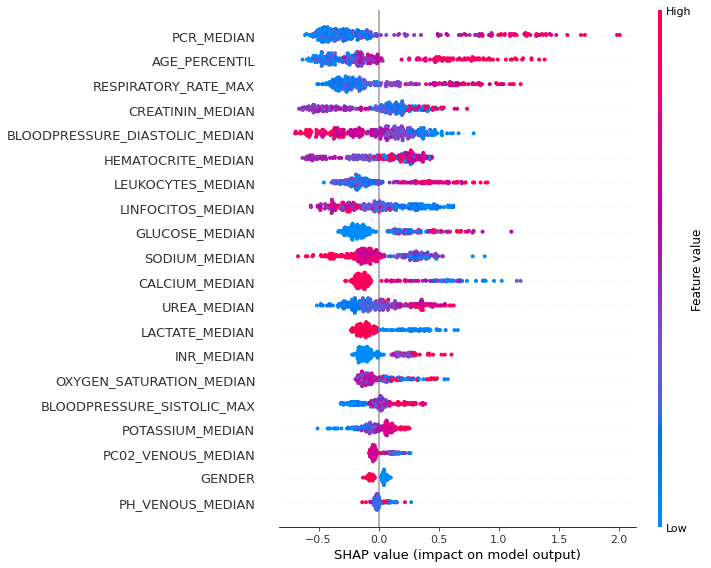

In [416]:
explica_modelo(xgboost_t, dados_preparados[colunas])

É válido notar que algumas variáveis aparentam causar um maior impacto no modelo do que outras. Entre elas, algumas se mostram bem comportadas, nas quais pacientes que possuem medidas baixas nelas apresentam maior ou menor tendência de serem internados. Alguns exemplos dessas variáveis seriam a **lactate_median**, **respiratory_rate_max** e **age_percentil**.

Pode-se ver o comportamento dessas variáveis na base de dados antes das manipulações. Nela é possível ver uma correlação entre os valores dessas variáveis e as internações. Por exemplo, na variável **lactate_median**, pacientes que não foram para a UTI apresentaram valores maiores dessa medida. Observa-se ainda por meio do gráfico dessa medida a clara diferença entre os pacientes que foram para a UTI e aqueles que não foram.

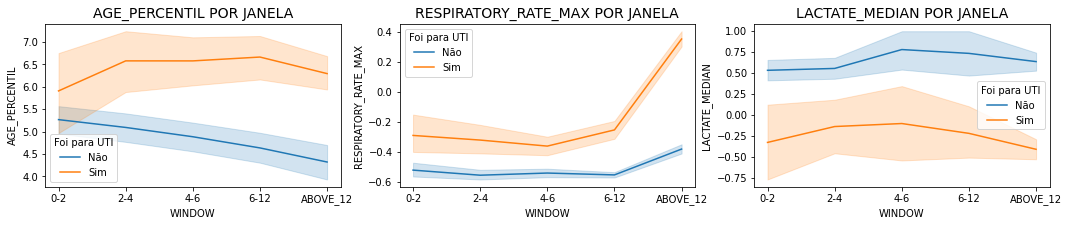

In [417]:
plot_variaveis_por_janela(dados_raw, ['AGE_PERCENTIL', 'RESPIRATORY_RATE_MAX', 'LACTATE_MEDIAN'])

## Conclusão

Em suma, foram realizados sobre a base de dados alguns tratamentos sobre estes, seguindo as indicações feitas pela equipe do hospital Sírio-Libanês; e separados os dados pertinentes às duas primeiras horas desde a entrada do paciente no hospital.

Foi então criada uma baseline com esses dados e com os modelos escolhidos para servir de padrão e guia na construção do modelo final.

Foram feitos alguns processos de eliminação de variáveis e a seleção das que permitiam uma melhor predição pelos modelos. A partir dessa base de dados reduzida, foram selecionados dois modelos que possuíam a melhor performance entre os inicialmente criados; e então feito então o ajuste dos hiperparâmetros desses modelos, identificando aquele com maior AUC em média entre eles.

Abaixo segue a *feature importance* ("peso atribuído às variáveis pelo modelo")  daquele modelo de maior AUC ao longo da validação cruzada, seguido de uma avaliação geral desse modelo ao final de um treinamento utilizando uma divisão dos dados de .8/.2 para treino e teste.

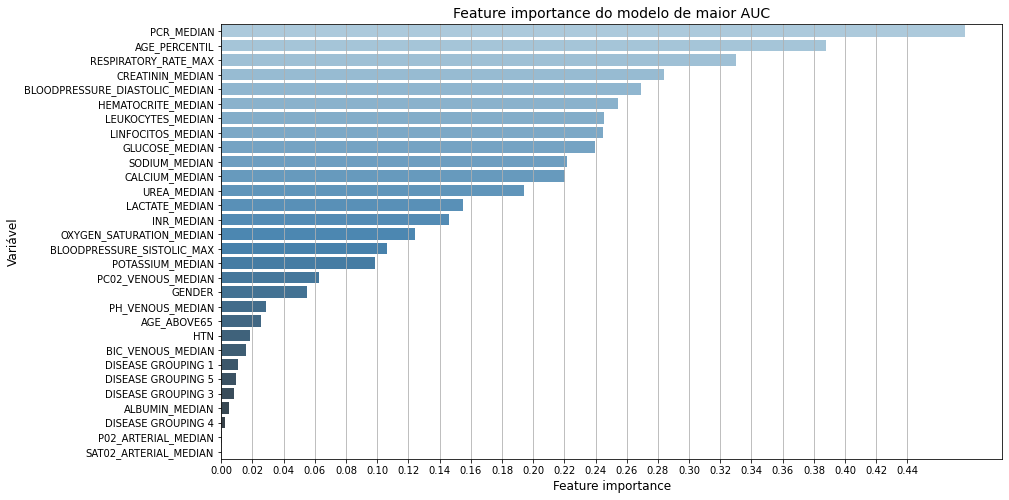

In [418]:
f_importance = shap_feature_importance(xgboost_t, dados_preparados[colunas])

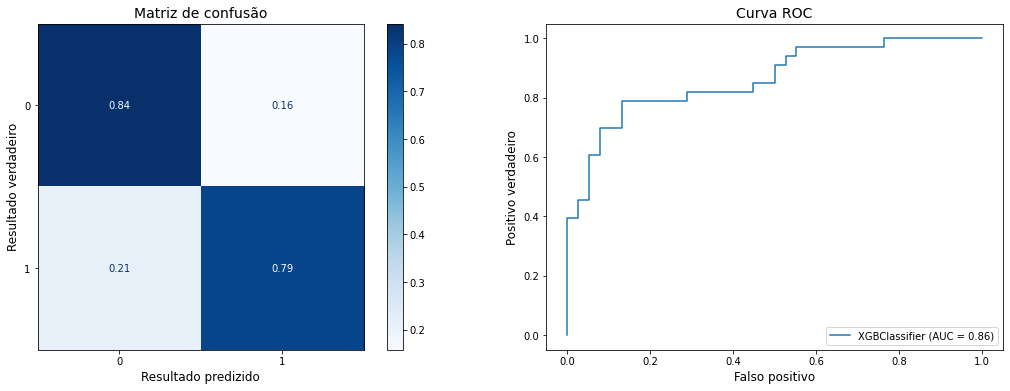

In [419]:
report = relatorio_geral(dados_preparados[colunas], xgboost_t)

In [420]:
print(report)

              precision    recall  f1-score   support

   UTI - NÃO       0.82      0.84      0.83        38
   UTI - SIM       0.81      0.79      0.80        33

    accuracy                           0.82        71
   macro avg       0.82      0.81      0.82        71
weighted avg       0.82      0.82      0.82        71



Como relatado acima, o modelo possui **0.81 de precision** (capacidade de não classificar como verdadeiro os dados falsos), **0.79 de recall** (capacidade de encontrar todas as predições corretas), contando com uma acurácia de **0.82**. Maiores detalhes sobre essas métricas podem ser encontrados na [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) oficial.

Finalmente, segue abaixo o modelo, hiperparâmetros e variáveis que geraram esses resultados.

In [421]:
xgboost_t

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.618,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=0, missing=nan, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1.3, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.8, verbosity=1)

In [421]:
colunas[:-2]